<h1> ENRON EMAILS: EXPLORATY DATA ANALYISIS <h1>

In [ ]:
#!pip install --user --upgrade pixiedust

In [12]:
import pixiedust

import pandas as pad
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql.types import  *
from pyspark.sql.functions import *
from pyspark.sql import *
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import Bucketizer

In [7]:
rawAnalytics_df = pixiedust.sampleData("https://raw.githubusercontent.com/manualrg/DSLAB_TextAnalytics/master/01_enron_rawAnalytics.csv")
print("Top 5 most frequent tokens: ")
rank_df.limit(5).toPandas()

Downloaded 2330340 bytes
Creating pySpark DataFrame for 'https://raw.githubusercontent.com/manualrg/DSLAB_TextAnalytics/master/01_enron_rawAnalytics.csv'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://raw.githubusercontent.com/manualrg/DSLAB_TextAnalytics/master/01_enron_rawAnalytics.csv'
Top 5 most frequent tokens: 


,token,ndocs,frequency,e,ne,eprop,freq_bins,ndocs_bins,logfreq_bins,rank,...,N0,P1,P0,x,WOEValue,token_length,WOEAbs,flg_singleLabel,WOERanks,lengthRanks
0,enron,512,4977,95,417,0.019088,3,2,3,1,...,716,0.683453,0.582402,1.173507,0.159997,5,0.159997,0,4,3
1,ect,361,4131,52,309,0.012588,3,2,3,2,...,716,0.374101,0.431564,0.866848,-0.142891,3,0.142891,0,3,2
2,com,332,3625,80,252,0.022069,3,2,3,3,...,716,0.575540,0.351955,1.635263,0.491804,3,0.491804,0,4,2
3,hou,329,2051,46,283,0.022428,3,2,3,4,...,716,0.330935,0.395251,0.837278,-0.177599,3,0.177599,0,3,2
4,e,268,1318,66,202,0.050076,3,2,3,5,...,716,0.474820,0.282123,1.683026,0.520593,1,0.520593,0,4,1


With these metrics, we can answer the following questions:
1. How does the WOE distribution looks like?
2. Is there a relationship between token frequency and WOE?
3. Is there a relationship between token length and WOE?

In order to perform our analysis, let's bucketize the variable WOEValues so we can handle infinite values, and then compute statistics by bucket. Firstly, let's visualize the distribution of WOEValue and then, assign ranges in order to build buckets that allocate the singleClass tokens in independent buckets: 

<h2> 1. Univariate WOEValues analysis <h2>


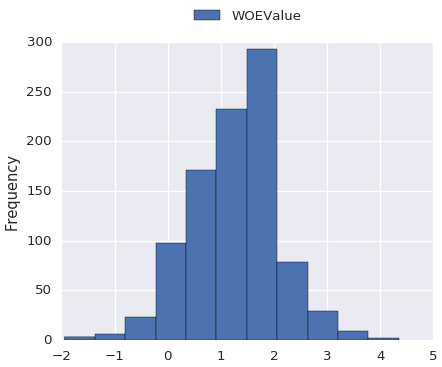

In [9]:
woe_space = rawAnalytics_df.filter(col("flg_singleLabel") == lit(0)).select("WOEValue","eprop")
display(woe_space)

Sampling with Pixiedust 1000 observations, we can see that, most of the tokens yield a WOEValue between 1 and 2. Let's split WOEValue space, but also, token_lenght, as we will need it later.

In [19]:
woe_splits = [-float("inf"), -2.5, -1.0, -0.5, 0.0, 0.75, 2.0, 4.5, float("inf")]
len_splits = [0.0, 1.0, 2.0, 4.0, 10.0, 20.0, 40.0, float("inf")]
woe_bucketizer = Bucketizer().setInputCol("WOEValue").setOutputCol("WOERanks").setSplits(woe_splits)
len_bucketizer = Bucketizer().setInputCol("token_length").setOutputCol("lengthRanks").setSplits(len_splits)
stages = [woe_bucketizer, len_bucketizer]
buckets_pl = Pipeline().setStages(stages).fit(rawAnalytics_df)
analytics_df = buckets_pl.transform(rawAnalytics_df)

analytics_df.persist()
rawAnalytics_df.unpersist()

analytics_df.limit(5).toPandas()

,token,ndocs,frequency,e,ne,eprop,freq_bins,ndocs_bins,logfreq_bins,rank,N1,N0,P1,P0,WOEValue,token_length,WOEAbs,flg_singleLabel,WOERanks,lengthRanks
0,enron,512,4977,95,417,0.019088,3,2,3,1,139,716,0.683453,0.582402,0.159997,5,0.159997,0,4,3
1,ect,361,4131,52,309,0.012588,3,2,3,2,139,716,0.374101,0.431564,-0.142891,3,0.142891,0,3,2
2,com,332,3625,80,252,0.022069,3,2,3,3,139,716,0.575540,0.351955,0.491804,3,0.491804,0,4,2
3,hou,329,2051,46,283,0.022428,3,2,3,4,139,716,0.330935,0.395251,-0.177599,3,0.177599,0,3,2
4,e,268,1318,66,202,0.050076,3,2,3,5,139,716,0.474820,0.282123,0.520593,1,0.520593,0,4,1



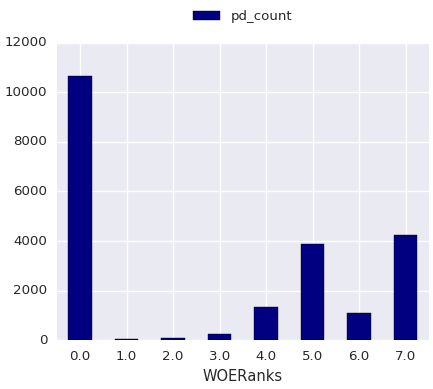

In [57]:
#Automatic aggregation and displaying of a PySpark DataFrame using Pixiedust
display(analytics_df)

Instead of ploting the PySpark DataFrame, let's compute some statistics and visualize it using matplotlib

In [28]:
analytics_stats_df = analytics_df.groupBy("WOERanks").\
    agg(max("WOEValue").alias("max"), min("WOEValue").alias("min"), avg("WOEValue").alias("avg"), count("*").alias("N"), 
        avg("eprop").alias("avg_eprop"), min("eprop").alias("min_eprop"), max("eprop").alias("max_eprop"),
        avg("frequency").alias("avg_frequency"), min("frequency").alias("min_frequency"), max("frequency").alias("max_frequency"),
        avg("token_length").alias("avg_token_length"), min("token_length").alias("min_token_length"), max("token_length").alias("max_token_length")).\
    orderBy(col("WOERanks"))
print("Statistics by WOERank")
analytics_stats = analytics_stats_df.toPandas()
analytics_stats

Statistics by WOERank


,WOERanks,max,min,avg,N,avg_eprop,min_eprop,max_eprop,avg_frequency,min_frequency,max_frequency,avg_token_length,min_token_length,max_token_length
0,0,-inf,-inf,-inf,10672,0.000000,0.000000,0.000000,2.327024,1,127,6.665480,0,58
1,1,-1.101634,-2.098463,-1.351600,37,0.033547,0.010638,0.058824,40.675676,17,175,5.513514,2,12
2,2,-0.500860,-0.999851,-0.687900,91,0.062496,0.014388,0.100000,41.362637,10,384,6.098901,2,14
3,3,-0.013717,-0.440235,-0.236550,263,0.091944,0.012588,0.160000,63.121673,7,4131,6.273764,1,14
4,4,0.745388,0.003451,0.422292,1322,0.164040,0.019088,0.285714,50.201210,4,4977,6.425113,1,19
5,5,1.995881,0.751903,1.379814,3891,0.331026,0.018519,0.571429,22.659214,2,1213,6.634798,1,16
6,6,4.347256,2.006931,2.489427,1077,0.515450,0.021505,0.857143,15.990715,3,782,7.053853,2,15
7,7,inf,inf,inf,4222,0.891200,0.024390,1.000000,1.721459,1,41,7.034818,2,27


WOERanks 3 and 4 are the subset of tokens that yield low predictive power (WOEValue around 0), and tokens that belong to a unique class (label=1 or label=0) are in buckets 7 and 0, respectively

To better understand those metrics let's use some visualizations, with matplotlib we can use the panda DataFrame or directly to plot the PySpark DataFrame with Pixiedust

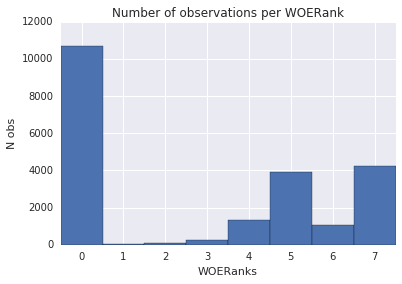

In [56]:
%matplotlib inline
w=1.0
ind = np.arange(0,8)+w/2
WOERanks = np.arange(0,8)


plt.bar(analytics_stats['WOERanks'], analytics_stats['N'], width=w)
# Label the axes
plt.xlabel('WOERanks')
plt.xticks(ind, WOERanks)
plt.ylabel('N obs')
#label the figure
plt.title('Number of observations per WOERank')
plt.show()

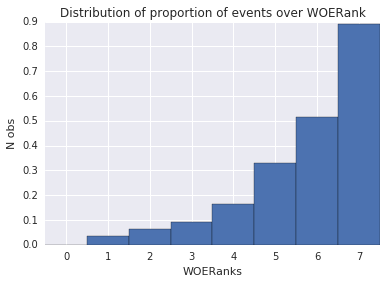

In [58]:
plt.bar(analytics_stats['WOERanks'], analytics_stats['avg_eprop'], width=w)
# Label the axes
plt.xlabel('WOERanks')
plt.xticks(ind, WOERanks)
plt.ylabel('N obs')
#label the figure
plt.title('Distribution of proportion of events over WOERank')
plt.show()

It seems that buckets have been assigned properly because we get a smooth monotonic event proportion distribution.

<h2> 2.WOE and token frequency relationship  <h2>

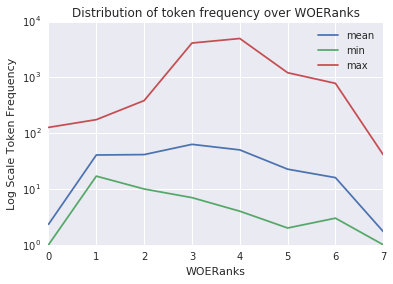

In [63]:
plt.semilogy(analytics_stats['WOERanks'], analytics_stats['avg_frequency'], label='mean')
plt.semilogy(analytics_stats['WOERanks'],analytics_stats['min_frequency'], label='min')
plt.semilogy(analytics_stats['WOERanks'], analytics_stats['max_frequency'], label='max')
# Label the axes
plt.xlabel('WOERanks')
plt.ylabel('Log Scale Token Frequency')
#label the figure
plt.title('Distribution of token frequency over WOERanks')
plt.legend(loc=0)
plt.show()

There is no variation of mean token frequency among WOERanks groups, except extreme values. At WOERanks={0, 7} token frequency is significantly lower, and every token in that buckets appears less than 100 times.

On the other hand, WOERanks={3, 4} have some very frequent terms, recall that those buckets contain tokens with low predictive power, so dropping then may be a good strategy in order to reduce computation time. Besides, take into account that WOERanks={3, 4} is the subset that contains **the least** number of tokens (as we could see in Number of observations per WOERanks plot), nevertheless, those are the most frequent ones.


Let's check out what kind of tokens appear in WOERanks={3, 4}

In [71]:
analytics_df.filter(col("WOERanks").isin([3,4]) ).\
    select("token", "token_length", "frequency", "ne", "e", "eprop", "WOEValue").\
    sort(col("frequency").desc()).limit(10).\
    toPandas()

,token,token_length,frequency,ne,e,eprop,WOEValue
0,enron,5,4977,417,95,0.019088,0.159997
1,ect,3,4131,309,52,0.012588,-0.142891
2,com,3,3625,252,80,0.022069,0.491804
3,hou,3,2051,283,46,0.022428,-0.177599
4,e,1,1318,202,66,0.050076,0.520593
5,2000,4,1058,249,78,0.073724,0.478462
6,subject,7,992,451,103,0.103831,0.162468
7,2001,4,968,237,56,0.057851,0.196498
8,mail,4,891,126,29,0.032548,0.170220
9,pm,2,860,350,77,0.089535,0.125079


Enron is the most frequent token, and it has a low predictive power. Let's think of it. It is very likely that "enron" appears in both label 1 and 0 class, and this is a very common issue in sentiment analytics, if we want to determine whether people is happy or not about the last iphone, words like apple, iphone, etc. may appear in positive and negative reviews.

<h2> 3.WOE and token length relationship <h2>

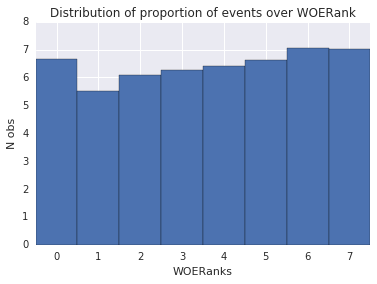

In [72]:
plt.bar(analytics_stats['WOERanks'], analytics_stats['avg_token_length'], width=w)
# Label the axes
plt.xlabel('WOERanks')
plt.xticks(ind, WOERanks)
plt.ylabel('N obs')
#label the figure
plt.title('Distribution of proportion of events over WOERank')
plt.show()

In [73]:
analytics_df.groupBy("lengthRanks").\
    agg(mean("token_length"), min("token_length"), max("token_length")).\
    sort("lengthRanks").toPandas()

,lengthRanks,avg(token_length),min(token_length),max(token_length)
0,0,0.000000,0,0
1,1,1.000000,1,1
2,2,2.809564,2,3
3,3,6.391410,4,9
4,4,11.231444,10,19
5,5,25.166667,20,38
6,6,47.333333,40,58


We have computed some token length buckets to ease the analysis, the most common bucket is number three that contains tokens whose length is between 4 and 9

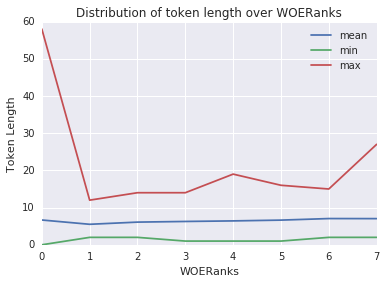

In [74]:
plt.plot(analytics_stats['WOERanks'], analytics_stats['avg_token_length'], label='mean')
plt.plot(analytics_stats['WOERanks'],analytics_stats['min_token_length'], label='min')
plt.plot(analytics_stats['WOERanks'], analytics_stats['max_token_length'], label='max')
# Label the axes
plt.xlabel('WOERanks')
plt.ylabel('Token Length')
#label the figure
plt.title('Distribution of token length over WOERanks')
plt.legend(loc=0)
plt.show()

On average, there are not any change in average token length by WOERank group. However, there are some outliers with very high lenght, let's check that it is not a data cleaning issue

In [79]:
analytics_df.filter(col("token_length") >= lit(25)).\
    select("token", "frequency", "token_length", "WOEValue").\
    sort(col("token_length").desc()).limit(10).toPandas()

,token,frequency,token_length,WOEValue
0,4444444444444444444444444444444444444444444444...,1,58,-inf
1,commonlegalsdicksonagreementscrestarspotcnfm,1,44,-inf
2,c170490e40fad1118dd900805fa7335f03fbfb9d,1,40,-inf
3,b5a43ee0e828d411a04500005a42a7b13d708b,1,38,-inf
4,00ff6cb5c984d211b44000a024686d8d2c3e25,1,38,-inf
5,largecustomerserviceoptions,1,27,-inf
6,columbiagastransmissioncorp,1,27,inf
7,portlandwestdeskcalifornia,1,26,-inf


This is a very important discovery! In fact there are very low frequency terms that are ids or web tokens or other sort of strings and have a ver low corpus frequency, so they only appear (by chance) in one class. When creating our vocabulary set, a good strategy is to get rid of corpus low frequency tokens, in order to avoid overfitting, instead of developing complex parsing rules to remove them by hand.

To create an interaction plot between WOERanks, token length rank and mean token frequency, we need to compute it from the PySpark DataFrame, so we must use PixieDust. It allows us to render with matplotlib, bokeh or brunel. Let's use a Bokeh visualization!

In [80]:
display(analytics_df)

It can be concluded that, at extreme WOE values (tokens that appear only in label 0 or 1 documents) there are some low frequency, high length tokens. While, in WOE buckets 3 and 4, there are some low length but very high frequency tokens.

Finally, let's display top most frequent tokens in each WOERanks level, so we can get a glance at each bucket.

In [93]:
buckets = range(0, 8)
for i in buckets:
    print('WOERanks: ', i)
    analytics_df.\
        filter(col("WOERanks")==lit(i)).\
        select("token", "rank", "frequency", "eprop", "WOEValue").\
        sort(col("frequency").desc()).\
        limit(10).\
        show()

('WOERanks: ', 0)
+-------------+----+---------+-----+---------+
|        token|rank|frequency|eprop| WOEValue|
+-------------+----+---------+-----+---------+
|         sara| 266|      127|  0.0|-Infinity|
|         tana| 362|      101|  0.0|-Infinity|
|          wpd| 369|      100|  0.0|-Infinity|
|   shackleton| 373|       97|  0.0|-Infinity|
|       folder| 392|       93|  0.0|-Infinity|
|synchronizing| 403|       92|  0.0|-Infinity|
|         isda| 598|       65|  0.0|-Infinity|
|       master| 594|       65|  0.0|-Infinity|
|          ews| 874|       46|  0.0|-Infinity|
|         mapp| 934|       43|  0.0|-Infinity|
+-------------+----+---------+-----+---------+

('WOERanks: ', 1)
+------------+----+---------+--------------------+-------------------+
|       token|rank|frequency|               eprop|           WOEValue|
+------------+----+---------+--------------------+-------------------+
|         lon| 164|      175|0.011428571428571429|-1.5994722183344265|
|counterparty| 390|  

Lastly, let's save this ranking of tokens

In [104]:
# The code was removed by DSX for sharing.

In [109]:
import ibmos2spark
file = "enron_analytics_rank.csv"
#credentials_1 is a code snippet from  files tab
configurationname1 = "os_" + (credentials_1["project"].replace("object_storage_", "").replace("_", "") ) + "_configs"
#configurationname: 0s_XXXXXX_configs where XXXXX is crendentils("project") substrancting ("object_storage_" and removing  every "_")

bmos = ibmos2spark.bluemix(sc,  credentials_1, configurationname1)
path = bmos.url(credentials_1["container"], file)

In [110]:
print("Saving a PySpark DataFrame as csv file to Bluemix Cloud Object Storage:")
print("Container name: " + credentials_1["container"])
print("File name: " + file)
analytics_df.coalesce(1).write.mode("overwrite").option("delimiter",",").\
    option("header","true").\
    option("treatEmptyValuesAsNulls", "true").\
    csv(path)

Saving a PySpark DataFrame as csv file to Bluemix Cloud Object Storage:
Container name: DSLABTextAnalytics
File name: enron_analytics_rank.csv
